# 01 Data Ingestion and EDA

This notebook implements MVP 1.2 requirements: data overview, univariate distribution checks, treatment-control covariate balance diagnostics, and correlation scan.

## Section 0: Setup

In [1]:
import io
import os
import sys
from glob import glob
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from IPython.display import Markdown, display

# Avoid hardcoding the project root path
project_root = Path.cwd()
if project_root.name == 'notebooks':
    project_root = project_root.parent
# Add project root to sys.path to enable 'from src.xxx import' syntax.
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Change working directory to project root for consistent path resolution
os.chdir(project_root)

from src.data_utils import load_and_clean

# Standardized plotting style
# Improves visual consistency and reviewer readability.
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 13
sns.set_palette('Set2')

config_candidates = [project_root / 'configs' / 'config.yaml', project_root / 'configs' / 'config.yml']
config_path = next((p for p in config_candidates if p.exists()), None)
if config_path is None:
    raise FileNotFoundError(f'No config file found. Searched: {[str(p) for p in config_candidates]}')

# Load config
with open(config_path, 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

# Extract paths and create output directory
raw_data_path = config['paths']['raw_data']
cleaned_data_path = config['paths']['cleaned_data']
raw_text_path = config['paths']['raw_text_data']
figures_dir = Path(config['paths']['figures_dir'])
figures_dir.mkdir(parents=True, exist_ok=True)

# If you want to overwrite existing output file, set overwrite=True
# df = load_and_clean(filepath=raw_data_path, output_path=cleaned_data_path, raw_text_path=raw_text_path, overwrite=True)
df = load_and_clean(filepath=raw_data_path, output_path=cleaned_data_path, raw_text_path=raw_text_path, overwrite=True)
print(f'Data loaded successfully: shape={df.shape}')


Data loaded successfully: shape=(64000, 13)


Section 0 summary: 配置 `config.yml/yaml` 已经成功加载,数据入库流程采用 ELT ,数据清理已经通过 `load_and_clean()` 完成,并通过数据形状 `df.shape` 已确认数据准备就绪.

## Section 1: Data overview

In [2]:
# ---------------------------------
# 1.1 Cleaned Data Overview
# ---------------------------------
buffer = io.StringIO()
df.info(buf=buffer)
print(buffer.getvalue())

# Normally, df.describe() only includes numeric columns
# 'all': include numeric and object columns
display(df.describe(include='all').transpose())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          64000 non-null  int64  
 1   history_segment  64000 non-null  object 
 2   history          64000 non-null  float64
 3   mens             64000 non-null  int64  
 4   womens           64000 non-null  int64  
 5   zip_code         64000 non-null  object 
 6   newbie           64000 non-null  int64  
 7   channel          64000 non-null  object 
 8   segment          64000 non-null  object 
 9   visit            64000 non-null  object 
 10  conversion       64000 non-null  int64  
 11  spend            64000 non-null  float64
 12  treatment        64000 non-null  int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 6.3+ MB



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
recency,64000.0,NaN,NaN,NaN,5.763734,3.507592,1.0,2.0,6.0,9.0,12.0
history_segment,64000,7,1) $0 - $100,22970,NaN,NaN,NaN,NaN,NaN,NaN,NaN
history,64000.0,NaN,NaN,NaN,242.085656,256.158608,29.99,64.66,158.11,325.6575,3345.93
mens,64000.0,NaN,NaN,NaN,0.551031,0.497393,0.0,0.0,1.0,1.0,1.0
womens,64000.0,NaN,NaN,NaN,0.549719,0.497526,0.0,0.0,1.0,1.0,1.0
zip_code,64000,3,Surburban,28776,NaN,NaN,NaN,NaN,NaN,NaN,NaN
newbie,64000.0,NaN,NaN,NaN,0.50225,0.499999,0.0,0.0,1.0,1.0,1.0
channel,64000,3,Web,28217,NaN,NaN,NaN,NaN,NaN,NaN,NaN
segment,64000,3,Womens E-Mail,21387,NaN,NaN,NaN,NaN,NaN,NaN,NaN
visit,64000,2,0,54606,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# --------------------------------
# 1.2 Missing/NULL value counts
# --------------------------------
# If exists NULL values, load_and_clean_data() did not work properly
missing_stats = df.isnull().sum().sort_values(ascending=False)
display(missing_stats.to_frame('missing_count'))
assert int(missing_stats.sum()) == 0, 'MVP 1.1 cleaning quality issue: null values detected'

,missing_count
recency,0
history_segment,0
history,0
mens,0
womens,0
zip_code,0
newbie,0
channel,0
segment,0
visit,0


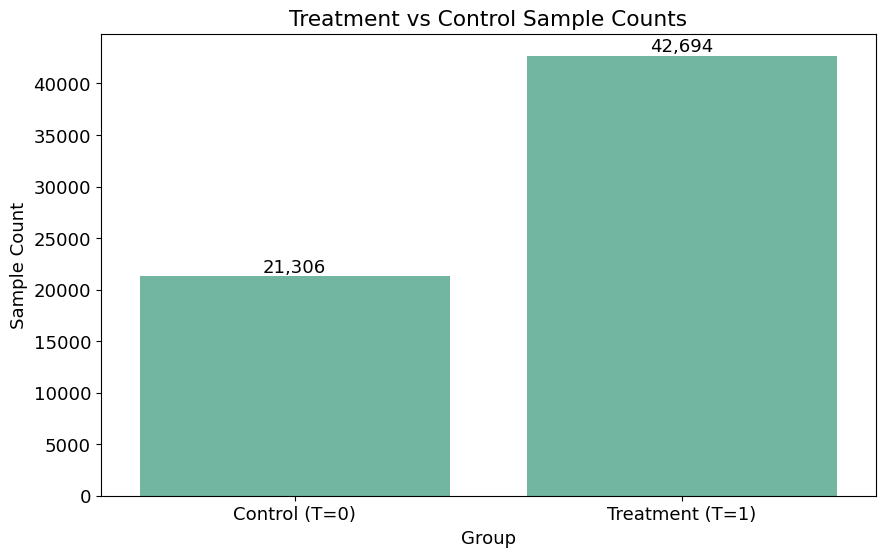

In [4]:
# -----------------------------------
# 1.3 Control/Treatment Sample Counts
# -----------------------------------
group_counts = df['treatment'].value_counts().sort_index()
label_map = {0: 'Control (T=0)', 1: 'Treatment (T=1)'}

# .reset_index(): .value_counts() returns a Series
# sns.barplot() requires a DataFrame
plot_df = group_counts.rename(index=label_map).reset_index()
plot_df.columns = ['group', 'count']

ax = sns.barplot(data=plot_df, x='group', y='count')
ax.set_title('Treatment vs Control Sample Counts')
ax.set_xlabel('Group')
ax.set_ylabel('Sample Count')
for p in ax.patches:
    # Add counts annotation
    ax.annotate(
        f"{int(p.get_height()):,}",                         # Add thousands separator
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='bottom'
    )

# Notice: will overwrite existing file
plt.savefig(figures_dir / 'eda_treatment_control_counts.png', dpi=150, bbox_inches='tight')
plt.show()

assert df['treatment'].value_counts().min() > 10000, 'Group sample size too small for robust comparison'

# --------------------------------------------------
# In production, use a dedicated file path:

#timestamp = datetime.now(timezone(timedelta(hours=8))).strftime("%Y%m%d_%H%M%S")
#versioned_path = figures_dir / f'eda_treatment_control_counts_{timestamp}.png'
#plt.savefig(versioned_path, dpi=150, bbox_inches='tight')

# Update the latest symlink
#latest_link = figures_dir / 'eda_treatment_control_counts_latest.png'
#if latest_link.exists() or latest_link.is_symlink():
#    latest_link.unlink()
#latest_link.symlink_to(versioned_path.name)
#
#print(f" Saved: {versioned_path.name}")
#print(f" Latest link updated: {latest_link.name} -> {versioned_path.name}")
# --------------------------------------------------


Section 1 summary: 数据结构和描述统计显示各数据列格式正确，检查数据中空值验证了 `load_and_clean()` 函数正确运行，确认控制组和观察组都有足够的样本来进行下游分析。

## Section 2: Univariate Distribution

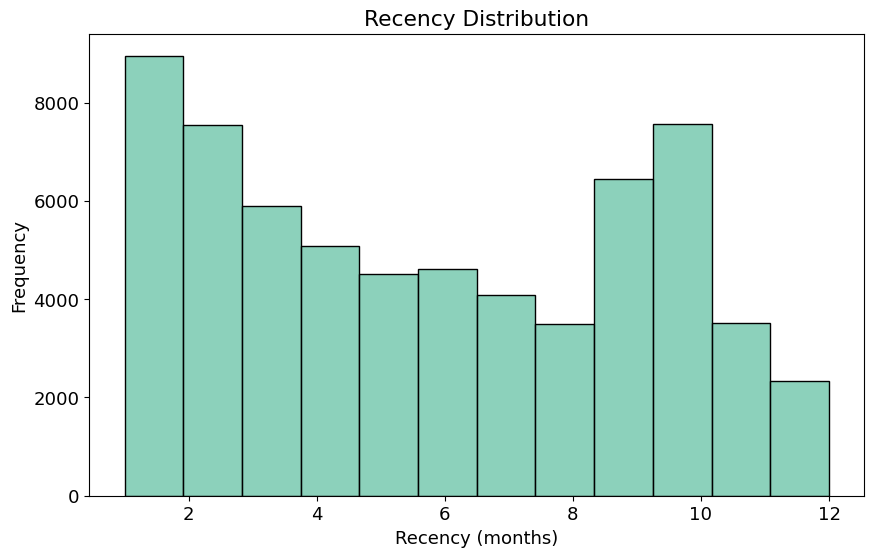

In [5]:
# ----------------------------------
# 2.1 Recency Distribution
# ----------------------------------
ax = sns.histplot(df['recency'], bins=12, kde=False)
ax.set_title('Recency Distribution')
ax.set_xlabel('Recency (months)')
ax.set_ylabel('Frequency')
plt.savefig(figures_dir / 'eda_recency_dist.png', dpi=150, bbox_inches='tight')
plt.show()

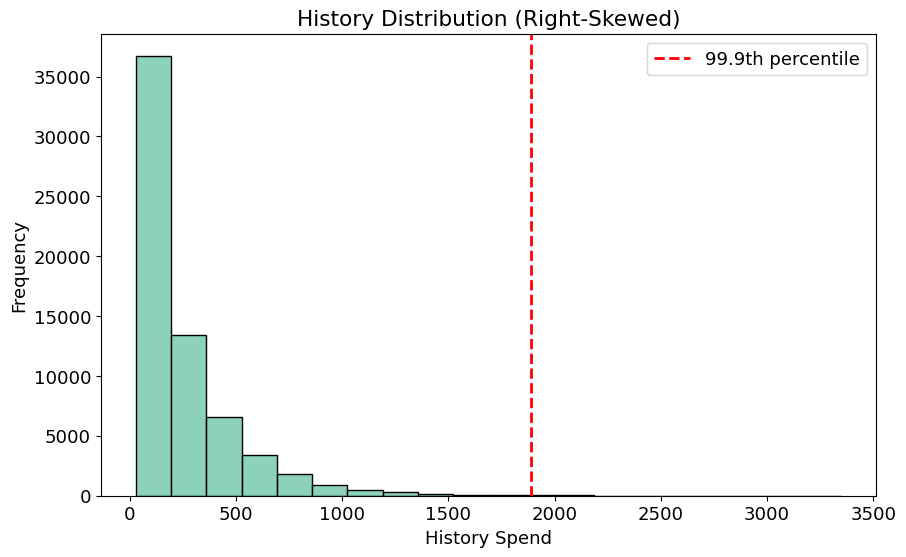

Skewness: 2.423796695859206
Kurtosis: 9.34672986107246


In [15]:
# ----------------------------------
# 2.2 History Distribution
# ----------------------------------
history_p999 = df['history'].quantile(0.999)
ax = sns.histplot(df['history'], bins=20, kde=False)
ax.axvline(history_p999, color='red', linestyle='--', linewidth=2, label='99.9th percentile')
ax.set_title('History Distribution (Right-Skewed)')
ax.set_xlabel('History Spend')
ax.set_ylabel('Frequency')
ax.legend()
plt.savefig(figures_dir / 'eda_history_dist.png', dpi=150, bbox_inches='tight')

skewness = df['history'].skew()
kurtosis = df['history'].kurtosis() 
plt.show()
print(f'Skewness: {skewness}')
print(f'Kurtosis: {kurtosis}')

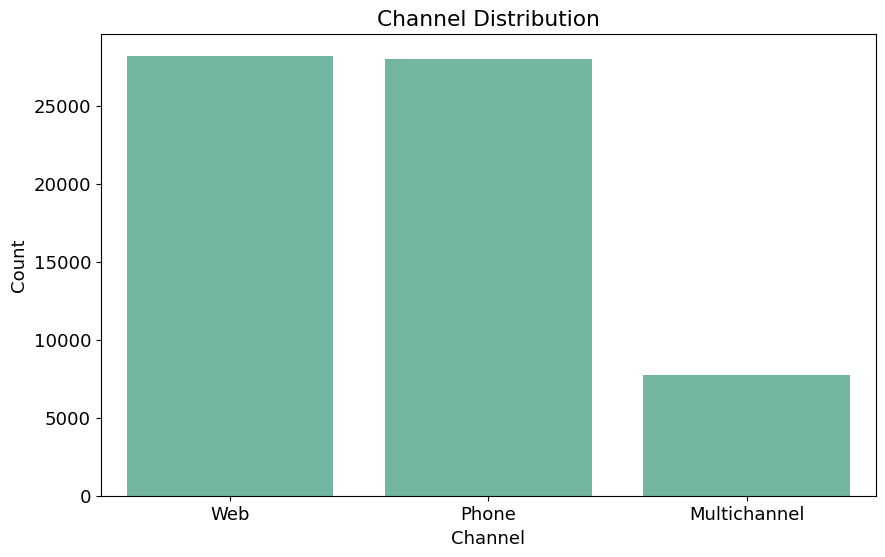

In [7]:
# ---------------------------------
# 2.3 Channel Distribution
# ---------------------------------
channel_counts = df['channel'].value_counts().reset_index()
channel_counts.columns = ['channel', 'count']
ax = sns.barplot(data=channel_counts, x='channel', y='count')
ax.set_title('Channel Distribution')
ax.set_xlabel('Channel')
ax.set_ylabel('Count')
plt.savefig(figures_dir / 'eda_channel_dist.png', dpi=150, bbox_inches='tight')
plt.show()

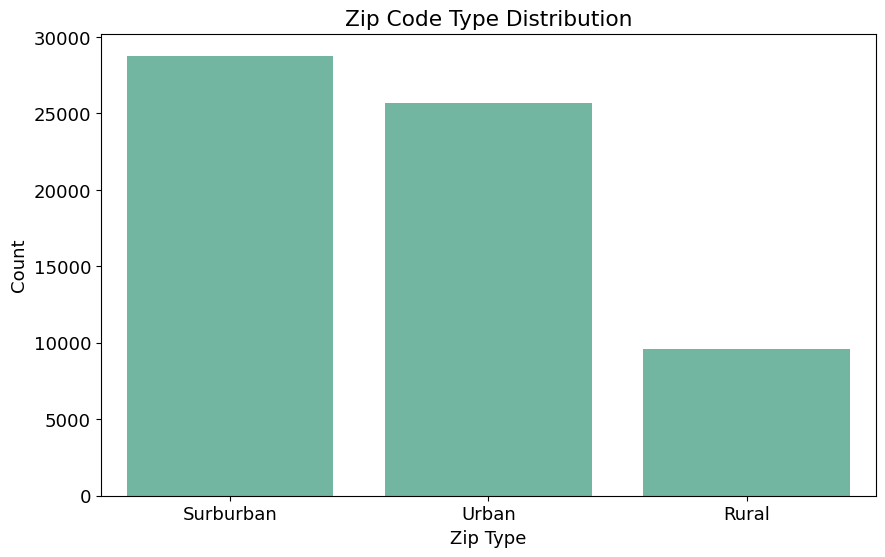

In [8]:
# ---------------------------------
# 2.4 Zip Code Distribution
# ---------------------------------
zip_counts = df['zip_code'].value_counts().reset_index()
zip_counts.columns = ['zip_code', 'count']
ax = sns.barplot(data=zip_counts, x='zip_code', y='count')
ax.set_title('Zip Code Type Distribution')
ax.set_xlabel('Zip Type')
ax.set_ylabel('Count')
plt.savefig(figures_dir / 'eda_zipcode_dist.png', dpi=150, bbox_inches='tight')
plt.show()

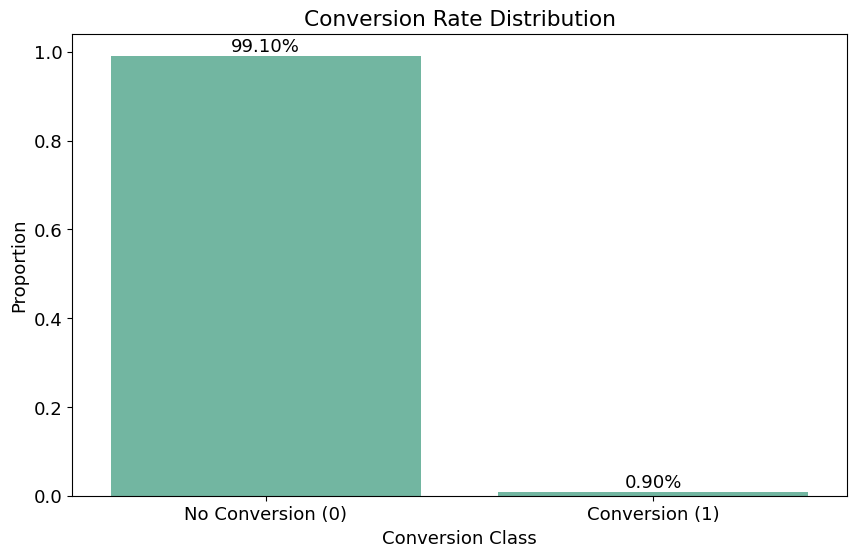

In [9]:
# --------------------------------
# 2.5 Conversion Rate Distribution
# --------------------------------
conversion_rate = df['conversion'].mean()
conv_plot_df = pd.DataFrame({
    'class': ['No Conversion (0)', 'Conversion (1)'],
    'rate': [1 - conversion_rate, conversion_rate]
})
ax = sns.barplot(data=conv_plot_df, x='class', y='rate')
ax.set_title('Conversion Rate Distribution')
ax.set_xlabel('Conversion Class')
ax.set_ylabel('Proportion')
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.2%}", 
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', 
        va='bottom'
    )
plt.savefig(figures_dir / 'eda_conversion_rate.png', dpi=150, bbox_inches='tight')
plt.show()

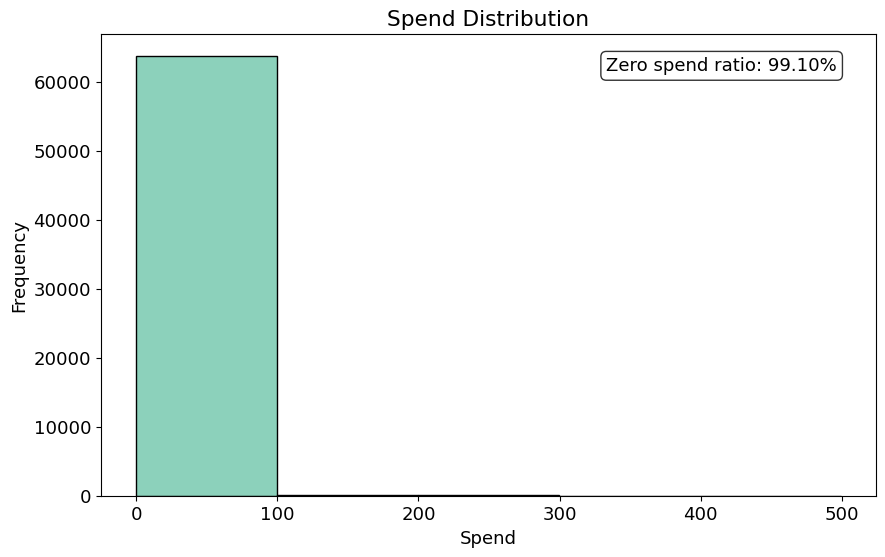

**Category Imbalance Warning:** conversion positive rate is below 5%; class imbalance handling should be considered in later modeling.

In [12]:
# --------------------------------
# 2.6 Zero Spend Rate & Conversion Rate Judgment
# --------------------------------
zero_spend_ratio = (df['spend'] == 0).mean()
ax = sns.histplot(df['spend'], bins=5, kde=False)
ax.set_title('Spend Distribution')
ax.set_xlabel('Spend')
ax.set_ylabel('Frequency')
ax.text(
    0.95, 
    0.95, 
    f'Zero spend ratio: {zero_spend_ratio:.2%}',
    transform=ax.transAxes, 
    ha='right', 
    va='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)
plt.savefig(figures_dir / 'eda_spend_dist.png', dpi=150, bbox_inches='tight')
plt.show()

if conversion_rate < 0.05:
    display(Markdown('**Category Imbalance Warning:** conversion positive rate is below 5%; class imbalance handling should be considered in later modeling.'))
else:
    display(Markdown('Conversion positive rate is above 5%; severe class imbalance risk is relatively lower at this stage.'))

Section 2 summary: 单变量分布确认了 `history` 的预期右偏和尖峰厚尾、明确的渠道/邮编分布结构，以及通过零支出比率可见的 `spend` 极度稀疏性。